# Recommending Best Neighbourhoods to Book Hotels
***
### Author : Erdal Eskikoy
**Description:**  
This capstone project is originaly developed for qualifying IBM Data Science Professional Certification.
Now I used it as a subject of my blog post: https://adatadetective.com/2019/01/23/datascience-capstone-recommend-hotel/
***


# Import Packages


In [86]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

from bs4 import BeautifulSoup
import requests, json 

import geocoder

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# We use StandardScaler() to normalize our dataset.
from sklearn.preprocessing import StandardScaler

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import os



# Introduction/Business Problem 

A travel agency which is specialized in arranging vacations for elderly French people, want to have a solution
to find out the right travel recommendation for their client's specific accomodation needs.

While the agency provide a bunch of detailed content via their web site, digging tons of pages and magazines
cost endless hours of their customers without making any desicion to book a holiday. The agency would like to provide some mechanism for their clients to shorten the time wasted in questing for desired holiday destinations and make them  take advantage of data science techniques to save time in their quest for finding best 


# 1. Introduction/Business Problem 

A travel agency which is specialised in arranging holidays for elderly French people, want to have a solution to find out the right travel recommendation for their client's specific accommodation needs of city tours.

While the agency provides a bunch of detailed content via their website, digging tons of pages and magazines cost endless hours of their customers without making any decision to book a holiday.

The agency states the following wishes of their customers to be meet for their guaranteed pleasant stay in the touristic destinations.

- They are elderly retired French people and they are not open to the cuisines other than French Kitchen. So they would like to eat at a French restaurant or Bistro. A destination neighbourhood having more French restaurants and bistros are preferable over other neighbourhoods having less.

- They would like to go to venues such as Museums, Performing Art Venues, Theatres and Movie Theatres. A neighbourhood with more of these venues are preferable over other neighbourhoods having less

- They would like to stay in hotels where all the venues (Restaurants, museums etc) should not be away more than 15 minutes walking distance. A hotel with lesser walking distance to venues is more preferable than the ones having a longer distance.

Based on the given customer profile and customer requirements, the agency would like to provide some mechanism for their clients to shorten the time wasted in searching for their ideal places to stay in the cities they want to visit. In other words, they would like to offer their clients some tool in their quest for finding the best neighbourhoods to stay in their desired destinations.




# 2. Analytic Approach & Learning Model
Based on the requirements mentioned in the Business Problem, we are not told about the best/right neighbourhoods and we can not make any distinctions between neighbourhouds regarding the requirements of the clients.
On the other hand, we are required to recommend the neighbourhoods having similar characteristics suited to the needs of the clients so that they can find out the desired vacation destination in a short period of time. In our situation, finding similarities of a given neighbourhoods can be best be addressed by Unsupervised Learning algorithms by grouping data in clusters. Therefore, we will use K-Means Clustering Algorithm.



# 3. Collect, Prepare and Clean Data
***

We need to collect appropriate data for segmentation of neighbourhoods such that they can satisfy the clients requirements.


### Initialize Neighboorhoods to include in Analysis
We do not include all the neighbourhoods in our project for a few reasons:
1. To avoid unexpected costs due to exceeding number of Google Distance Matrix API calls.
2. Increasing number of Neighbourhoods in the analysis causes performance issues due to Google API calls (Slow network response time after 100 API Calls)

In [87]:
neigbourhood_list=[]
neighbourhood_filter=["Stadsdriehoek/Rotterdam Centrum","Cool/Rotterdam Centrum","Rotterdam Centraal/Weena","Oude Westen","Dijkzigt","Scheepvaartkwartier/Nieuwe Werk","Middelland","Nieuwe Westen","Coolhaveneiland","Hillegersberg Centrum","Kralingen","Feijenoord/Noordereiland/Kop van Zuid","Afrikaanderwijk/Katendrecht","Oud-Charlois","Carnisse/Zuidplein","Waalhaven"]


### Initialize variables

During the course of data collection we will use Google Distance Matrix API and Foursquare Developer API's( therefore you need to have proper accounts Google Cloud Platform Account and Foursquare developer accounts) In order to make those API calls, we need to have some credentials such as Google API'keys and Foursquare Client Id & Secret. Let's set them below properly.

In [88]:
walking_duration=900 # walking distance from hotel to venues in seconds

fsq_version = '20180605' # Foursquare API version
fsq_limit = 100 # limit of number of venues returned by Foursquare API
fsq_venues_in_radius=1000 # search venues within this radius from city center

# Credentials to make Foursquare API Calls
# Set FSQ_CLIENT_ID,FSQ_CLIENT_SECRET as shell environment variable
fsq_client_id = os.environ.get('FSQ_CLIENT_ID')   #  Foursquare Developer API credential - Client Id
fsq_client_secret = os.environ.get('FSQ_CLIENT_SECRET') #  Foursquare Developer API credential - Client Secret

# Google API key to make Google Map API calls (distance matrix api, geolocation api etc)
# Set GOOGLE_API_KEY as shell environment variable
google_api_key = os.environ.get('GOOGLE_API_KEY')

fsq_venue_categories_filter = [
    { 'category': 'Hotel',                 'id': '4bf58dd8d48988d1fa931735'},
    { 'category': 'Movie Theater',         'id': '4bf58dd8d48988d17f941735'},
    { 'category': 'Theater',               'id': '4bf58dd8d48988d137941735'},  
    { 'category': 'French Restaurant',     'id': '4bf58dd8d48988d10c941735'},
    { 'category': 'Muesum',                'id': '4bf58dd8d48988d181941735'},
    { 'category': 'Music Venue',           'id': '4bf58dd8d48988d1e5931735'},
    { 'category': 'Performing Arts Venue', 'id': '4bf58dd8d48988d1f2931735'},    
    { 'category': 'Bistro',                'id': '52e81612bcbc57f1066b79f1'}
]
fsq_venue_categories_filter_df = pd.DataFrame(fsq_venue_categories_filter)

categories = ','.join(list(fsq_venue_categories_filter_df['id'].values))
category_list = fsq_venue_categories_filter_df['id'].values



***
# Functions used in this project
***

### Function to scrape neighbourhoods from Wikipedia

Using **BeatifulSoup**, this function scrapes the neighbourhoods from following wikipedia page. Note that this function can scrape only the specific page given below.
- [Neighbourhoods of Rotterdam](https://nl.wikipedia.org/wiki/Lijst_van_postcodes_3000-3999_in_Nederland)
      

In [89]:
def scrape_neighbourhoods_rotterdam():
    
    def prepare_neigbourhood_list(root_element):
        for neigbourhood_li_element in root_element:
            neigbourhood_name_list=[]
            if neigbourhood_li_element.find("a") != -1:
                postal_code_string=neigbourhood_li_element.contents[0].strip()
                postal_codes=postal_code_string.split("-")

                for neigbourhood_a_element in neigbourhood_li_element.findAll("a"):
                    neigbourhood_name_list.append(neigbourhood_a_element.get_text())
                
                neigbourhood_name='/'.join(neigbourhood_name_list)

                if len(postal_codes) == 2:                
                    neigbourhood_list.append({'Neighbourhood Postal Code':postal_codes[0], 'Neighbourhood':neigbourhood_name})
                    neigbourhood_list.append({'Neighbourhood Postal Code':postal_codes[1], 'Neighbourhood':neigbourhood_name})
                else: 
                    neigbourhood_list.append({'Neighbourhood Postal Code':postal_codes[0], 'Neighbourhood':neigbourhood_name})

    resp=requests.get('https://nl.wikipedia.org/wiki/Lijst_van_postcodes_3000-3999_in_Nederland')

    assert  resp.status_code == 200, "Http link to postal codes is not valid!"
    soup = BeautifulSoup(resp.text, 'html.parser')

    root_element=soup.find("a",title="Rotterdam Rechter Maasoever").parent.find("ul")
    prepare_neigbourhood_list(root_element)

    root_element=soup.find("a",title="Rotterdam-Zuid").parent.find("ul")
    prepare_neigbourhood_list(root_element)
    
    #  For given address of a neighbourhood, get geographic coordinates using geocoder 
    for neighbourhood_dict in neigbourhood_list:
        neighbourhood_address=neighbourhood_dict['Neighbourhood Postal Code'] + ', Rotterdam, NL'    
        g = geocoder.google(neighbourhood_address)
        neighbourhood_dict['Latitude']=g.latlng[0]
        neighbourhood_dict['Longitude']=g.latlng[1]

        print("Neighbourhood : {} Lat-Long : {}".format(neighbourhood_dict['Neighbourhood'], g.latlng))     


### Function to get walking distance from hotels to venues in seconds
Using Google Distance Matrix API, this function calculates the distance between for each given hotel en venue pairs stored in "row" parameter. 


In [90]:
def getDistanceDuration(row):    

        # set coordinates
        source = '{},{}'.format(row['Hotel Latitude'], row['Hotel Longitude'])
        dest= '{},{}'.format(row['Venue Latitude'], row['Venue Longitude'])
            
        # url variable store url  
        url ='https://maps.googleapis.com/maps/api/distancematrix/json?'
        
        # Get method of requests module 
        # return response object 
        r = requests.get(url + 'units=metric'
                        '&mode=walking'
                        '&origins=' + source +
                        '&destinations=' + dest +
                        '&key=' + google_api_key) 
                            
        # json method of response object 
        # return json format result 
        res = r.json() 
        distance_to_venue=res['rows'][0]['elements'][0]['distance']['value']
        time_to_venue=res['rows'][0]['elements'][0]['duration']['value']
        
        print('{} => Hotel :{} Venue:{} Distance:{}'.format(count_api_call,row['Hotel'],row['Venue'],distance_to_venue))

        return pd.Series([distance_to_venue,time_to_venue])


### Function to get venues within given radius from the centre of the Neighbourhood
Using Foursquare developer API, this function fetches all the venues based on the given venue categories falling into the radius from the center of the destination city.

In [91]:
def getNearbyVenues(neigbourhoods, postal_codes, latitudes, longitudes, radius=500):    
    venues_list=[]
    for neigbourhood_name, neighbourhood_postal_code, lat, lng in zip(neigbourhoods, postal_codes, latitudes, longitudes):
        print(neigbourhood_name)
            
        # create the API request URL to search venues around the given coordinates of ll(latitude,longitude)
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            fsq_client_id, 
            fsq_client_secret, 
            fsq_version, 
            lat, 
            lng, 
            categories,
            radius, 
            fsq_limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']

        # return only relevant information for each nearby venue    
        venues_list.append([(
            neigbourhood_name, 
            neighbourhood_postal_code,
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'], 
            v['location']['distance'], 
            (lambda v: v['location']['postalCode'] if 'postalCode' in v['location'] else 'Empty')(v), 
            (lambda v: v['location']['formattedAddress'] if 'address' in v['location'] else 'Empty')(v), 
            v['categories'][0]['name']) for v in results
                # venue's category should be a primary category contained in category_list
                if list(filter(lambda x: x['primary'], v['categories']))[0]['id'] in category_list 
            ])

    # prepare the relevant dataframe for all the venues fetched from Foursquare
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Postal Code',
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue',                    
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Distance',                              
                  'Venue Postal Code', 
                  'Venue formattedAddress',            
                  'Venue Category']
    
    return(nearby_venues)

### Function to deal with missing postal codes of some venues
After fetching the venues, we have observed that some venue's addresses were missing. We know that postal code is a very important feature that need to be filled with. Since one of main objective is to fullfill the requirement of finding out number of venues in a given neighbourhood. 
- This function below can fetch the postal codes for a given location addressed with geographic coordinates. It uses **geocoder** module which in turn uses Google Maps Geolocation API's


In [92]:
cnt=0
def getPostal(row):
    global cnt
    if (row['Venue Postal Code'] == 'Empty'):
        rg=geocoder.google([row['Venue Latitude'],row['Venue Longitude']], method='reverse')
        resJson2=rg.geojson
        postal=resJson2['features'][0]['properties']['postal']
        postal_prefix=postal.split(' ')[0][:4]
        result_series=pd.Series([postal_prefix,postal])
    else: 
        postal_prefix=row['Venue Postal Code'].split(' ')[0][:4]
        result_series=pd.Series([postal_prefix,row['Venue Postal Code']])

    cnt += 1
    print('Row No: {} => Neighbourhood: {} Venue: {} Lat-Long: {},{}'.format(cnt,row['Neighbourhood'],row['Venue'],row['Venue Latitude'],row['Venue Longitude']))
    return result_series


### Function to visualize neighbourhoods on OpenStreetMap

In [93]:
# create map demonstrating the segmentation of neighbourhoods
def showNeighbourdsInMap(neighbourhoods_df, city_address, lat=None, long=None):

    if lat and long:
        latitude = lat
        longitude = long
    else:            
        geolocator = Nominatim(user_agent="coursera-battle-of-neighbourhood")
        location = geolocator.geocode(city_address)
        latitude = location.latitude
        longitude = location.longitude
        
    print('The geograpical coordinate of Rotterdam are {}, {}.'.format(latitude, longitude))

    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i+x+(i*x)**2 for i in range(kclusters)]
    colors_array = cm.Dark2(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    # markers_colors = []
    for lat, lon, poi, poi_postal, cluster in zip(
                        neighbourhoods_df['Latitude'],
                        neighbourhoods_df['Longitude'],
                        neighbourhoods_df.reset_index()['Neighbourhood'],
                        neighbourhoods_df.reset_index()['Neighbourhood Postal Code'],
                        neighbourhoods_df['Cluster Labels']):
        label = folium.Popup(str(poi) + '-\n' + str(poi_postal) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
        
    return map_clusters


### Initialize variables related persisting fetched data
We are caching fetched data from  from Wikipedia, Foursquare and Google Maps for the following reasons
- The data we fetch is not changing dynamicaly.
- By the help of caching, we can avoid chance of exceeding daily API call limits inadvertantly

Neighbourhoods data that is scraped from Wikipedia is cached in file NEIGBOURHOODS_CSV
Venues fetched from Foursquare is cached in file VENUES_CSV
Hotel - Venu walking distance (queried by Google Distance Matrix API) and related venue features are kept in file HOTEL_VENUE_RELATION_CSV

In [94]:
NEIGBOURHOODS_CSV='./{}'.format('neighbourhoods.csv')
neighbourhoods_csv_exist = os.path.isfile(NEIGBOURHOODS_CSV)

VENUES_CSV='./{}'.format('venues.csv')
venues_csv_exist = os.path.isfile(VENUES_CSV)

HOTEL_VENUE_RELATION_CSV='./{}'.format('hotel_venue_relation.csv')
relation_csv_exist = os.path.isfile(HOTEL_VENUE_RELATION_CSV)


### Get Neighbourhoods
Scrape neighbourhoods data if not cached in local file system

In [95]:
if not neighbourhoods_csv_exist:
    scrape_neighbourhoods_rotterdam()
    neighbourhood_df=pd.DataFrame(neigbourhood_list)
    neighbourhood_df=neighbourhood_df[['Neighbourhood','Neighbourhood Postal Code','Latitude','Longitude']]
    neighbourhood_df.to_csv(NEIGBOURHOODS_CSV,index=False)
else:    
    neighbourhood_df=pd.read_csv(NEIGBOURHOODS_CSV,dtype={'Neighbourhood Postal Code': str})

some_neighbourhoods=neighbourhood_df['Neighbourhood'].isin(neighbourhood_filter)
neighbourhood_df=neighbourhood_df[some_neighbourhoods]


### Get Foursquare venues data
Fetch venues data from Foursquare if it is not cached in local file system

In [96]:
FORCE_REFRESH_API_DATA=False
if not venues_csv_exist or FORCE_REFRESH_API_DATA :    
    # Get nearby venues of the neighbourhood. Venues within a circle defined by the radius from the
    # center of neighbourhood will be selected
    venues_df=getNearbyVenues(neighbourhood_df['Neighbourhood'],neighbourhood_df['Neighbourhood Postal Code'], neighbourhood_df['Latitude'], neighbourhood_df['Longitude'],fsq_venues_in_radius)

    # clean venues that do not have a proper address
    is_empty=venues_df["Venue formattedAddress"]=="Empty"
    venues_df=venues_df[~is_empty] # not empty

    # update empty postal codes using reverse geocoding
    if not 'Venue Postal Code Prefix' in venues_df.columns:
        venues_df[['Venue Postal Code Prefix','Venue Postal Code']] = venues_df.apply(getPostal, axis=1)

    # persist venues 
    venues_df.to_csv(VENUES_CSV,index=False) 
else:
    assert venues_csv_exist,"ERR> venues.csv does not exists!!!"
    venues_df = pd.read_csv(VENUES_CSV,dtype={'Neighbourhood Postal Code': str})

# We have been asked Four Square API to return venues within given radius of Neighbourhoods
# But as you guess some venues will belong to another Neighbourhood.
venues_df['Neighbourhood Postal Code']=venues_df['Neighbourhood Postal Code'].astype(str)
venues_df['Venue Postal Code Prefix']=venues_df['Venue Postal Code Prefix'].astype(str)
# postal_equal=venues_df['Neighbourhood Postal Code'] == venues_df['Venue Postal Code Prefix']
# postal_equal=venues_df['Neighbourhood Postal Code'] == venues_df['Venue Postal Code Prefix']
#venues_df=venues_df[postal_equal]


### Prepare Hotel - Venue Relation Data
If hotel venue relation is not cached then
- Construct hvr_df dataframe which is hotel venue relation dataframe
- Get hotel - venue walking distance using Google Distance Matrix API
- Associate venues within given walking distance to Hotels
- Cache hvr_df to the local file system ( to HOTEL_VENUE_RELATION_CSV)

**The trickiest part of the problem is to relate the venues according to walking distances to hotels.**
The function **getDistanceDuration** will call the Google Distance Matrix API to calculate the walking distances from hotels to venues based on geolocation values.  In the very first execution of our code, after constructing hotel venue relations regarding walking distances, we will persist these relations in the CSV file hotel_venue_relation.csv for caching purposes. Here is a small segment of the contents of hotel_venue_relation.csv to demonstrate how it looks like.

In [97]:
FORCE_REFRESH_API_DATA=False
if not relation_csv_exist or FORCE_REFRESH_API_DATA :
    # PREPARE Hotel <-> Venue relation
    hotels_df=venues_df[venues_df['Venue Category'].str.contains('hotel',case=False)]
    hotels_df=hotels_df[['Neighbourhood','Neighbourhood Postal Code','Venue','Venue Latitude','Venue Longitude','Venue Postal Code Prefix','Venue Postal Code']]
    hotels_df.columns=['Neighbourhood','Neighbourhood Postal Code','Hotel','Hotel Latitude','Hotel Longitude','Hotel Postal Code Prefix','Hotel Postal Code']

    venues_min_hotels_df=venues_df[~venues_df['Venue Category'].str.contains('hotel',case=False)]
    venues_min_hotels_df=venues_min_hotels_df[['Neighbourhood','Neighbourhood Postal Code','Venue','Venue Category','Venue Latitude','Venue Longitude','Venue Postal Code Prefix','Venue Postal Code']]
    venues_min_hotels_df.columns=['Neighbourhood','Neighbourhood Postal Code','Venue','Venue Category','Venue Latitude','Venue Longitude','Venue Postal Code Prefix','Venue Postal Code']

    # Create hotel venue relation dataframe = hvr_df
    # hvr_df is the cartesian product  : hotels_df * venues_min_hotels_df
    hvr_df=pd.merge(hotels_df, venues_min_hotels_df, on=['Neighbourhood','Neighbourhood Postal Code'])

    # Eleminate Hotels which does not have the same postal code of its neighbourhood.
    # Note that hotel venues are fetched from Foursquare for a given Neighbourhood when they fall into the raidus from geographic coordinates of the neighbourhood 
    # But this does not necessarily mean they will have same postal code with their associated neighbourhood
    # Eleminate Hotels which does not have same postal code with their associated neighbourhood
    same_neighbouurhood_hotels=hvr_df['Neighbourhood Postal Code'] == hvr_df['Hotel Postal Code Prefix']
    hvr_df=hvr_df[same_neighbouurhood_hotels]

    # Add some calculated new columns
    hvr_df['General Venue Category']=hvr_df['Venue Category'].apply(lambda v: 'Museum' if v.lower().find('museum') > -1 else v)
    hvr_df['Venue Postal Code Prefix']=hvr_df['Venue Postal Code Prefix'].apply(lambda v: v.strip()[:4])
    hvr_df['Hotel Postal Code Prefix']=hvr_df['Hotel Postal Code Prefix'].apply(lambda v: v.strip()[:4])
    
    # drop rows which have hotels and venues not in the same postal code region 
    # postal_not_equal=hvr_df['Hotel Postal Code Prefix'] != hvr_df['Venue Postal Code Prefix']
    # hvr_df.drop(hvr_df[postal_not_equal].index, inplace=True)

    # get walking distance from hotels to venues
    # NOTE  that in case of many neighbourhoods inclueded in the analysis;
    # the number of google API Distance matrix calls might exceed daily quota of free API calls. 
    if not 'Distance To Hotel' in hvr_df.columns:
        hvr_df[['Distance To Hotel','Time To Hotel']] = hvr_df.apply(getDistanceDuration, axis=1)

    hvr_df.to_csv(HOTEL_VENUE_RELATION_CSV,index=False)
else:    
    assert relation_csv_exist,"ERR > hvr_df.csv does not exist!!!"
    hvr_df = pd.read_csv(HOTEL_VENUE_RELATION_CSV,dtype={'Neighbourhood Postal Code': str})

# Use "cut" when to segment time to walk from hotel to venue
# keep the number of google API Distance matrix acceptable level to avoid unexpected costs!
walking_duration_labels = ["{0} - {1} mins walk".format(i/60,i/60+5) for i in range(0, 3600, 300)]
hvr_df['Walking Duration Category']=pd.cut(hvr_df['Time To Hotel'], range(0, 3601, 300), right=False, labels=walking_duration_labels)

# Eleminate venues out of given walking distance
in_walking_distance=hvr_df['Time To Hotel'] <= walking_duration
hvr_df=hvr_df[in_walking_distance]

hvr_df.head()


,Neighbourhood,Neighbourhood Postal Code,Hotel,Hotel Latitude,Hotel Longitude,Hotel Postal Code Prefix,Hotel Postal Code,Venue,Venue Category,Venue Latitude,Venue Longitude,Venue Postal Code Prefix,Venue Postal Code,General Venue Category,Distance To Hotel,Time To Hotel,Walking Duration Category
2,Stadsdriehoek/Rotterdam Centrum,3011,H2otel,51.917393,4.487061,3011,3011 WR,Kijk-Kubus Museum,Museum,51.920324,4.490141,3011,3011 MH,Museum,585,462,5.0 - 10.0 mins walk
3,Stadsdriehoek/Rotterdam Centrum,3011,H2otel,51.917393,4.487061,3011,3011 WR,Hartig,Bistro,51.916484,4.478033,3012,3012 VA,Bistro,822,629,10.0 - 15.0 mins walk
4,Stadsdriehoek/Rotterdam Centrum,3011,H2otel,51.917393,4.487061,3011,3011 WR,Rodin,French Restaurant,51.916299,4.481174,3011,3011 ES,French Restaurant,566,440,5.0 - 10.0 mins walk
8,Stadsdriehoek/Rotterdam Centrum,3011,H2otel,51.917393,4.487061,3011,3011 WR,Pierre,French Restaurant,51.923737,4.487523,3011,3011LH,French Restaurant,984,743,10.0 - 15.0 mins walk
14,Stadsdriehoek/Rotterdam Centrum,3011,ibis Rotterdam City Centre,51.917347,4.488301,3011,3011 WP,Kijk-Kubus Museum,Museum,51.920324,4.490141,3011,3011 MH,Museum,541,430,5.0 - 10.0 mins walk


Check a slice of the data frame to see walking duration (in seconds) and distances (in meters) between Hotels and Venues. 

In [98]:
hvr_df[['Neighbourhood','Hotel','Venue','Distance To Hotel','Time To Hotel']].head()

,Neighbourhood,Hotel,Venue,Distance To Hotel,Time To Hotel
2,Stadsdriehoek/Rotterdam Centrum,H2otel,Kijk-Kubus Museum,585,462
3,Stadsdriehoek/Rotterdam Centrum,H2otel,Hartig,822,629
4,Stadsdriehoek/Rotterdam Centrum,H2otel,Rodin,566,440
8,Stadsdriehoek/Rotterdam Centrum,H2otel,Pierre,984,743
14,Stadsdriehoek/Rotterdam Centrum,ibis Rotterdam City Centre,Kijk-Kubus Museum,541,430


***
# 4. Clustering Data
***

### Preparing Data for Clustering
Prepare dataframe for applying K-Mean Clustering Algorithm to cluster neighbourhoods

In [99]:
# find total venues count ( other then hotels ) per neighbourhood
venues_min_hotels_df=venues_df[~venues_df['Venue Category'].str.contains('hotel',case=False)]
venues_count_series=venues_min_hotels_df.groupby(['Neighbourhood', 'Neighbourhood Postal Code'])['Venue'].count()
venues_count_df=pd.DataFrame(venues_count_series)
venues_count_df.columns=['Total Venue Count']

# hvr_grouped_df=hvr_df.groupby(['Neighbourhood','Neighbourhood Postal Code','Hotel','General Venue Category']).agg({'Venue': np.size, 'Time To Hotel':np.median}).reset_index()
hvr_grouped_df=hvr_df.groupby(['Neighbourhood','Neighbourhood Postal Code','Hotel']).agg({'Venue': np.size, 'Time To Hotel':np.median}).reset_index()
model_df=hvr_grouped_df.groupby(['Neighbourhood','Neighbourhood Postal Code']).agg({'Venue': np.mean, 'Time To Hotel':np.mean, 'Hotel':np.size})
model_df.columns=['Avg Venue Per Hotel In Given Walking Distance', 'Avg Walking Time To Hotel', 'Total Hotel Count']
model_df=model_df.join(venues_count_df)

model_df


,,Avg Venue Per Hotel In Given Walking Distance,Avg Walking Time To Hotel,Total Hotel Count,Total Venue Count
Neighbourhood,Neighbourhood Postal Code,,,,
Afrikaanderwijk/Katendrecht,3072,11.400000,541.000000,5,21
Cool/Rotterdam Centrum,3012,10.833333,573.833333,6,14
Coolhaveneiland,3024,14.000000,352.500000,2,18
Dijkzigt,3015,12.333333,411.000000,3,16
Feijenoord/Noordereiland/Kop van Zuid,3071,9.000000,545.000000,1,15
Middelland,3021,8.000000,611.500000,3,16
Oude Westen,3014,9.000000,595.000000,1,16
Rotterdam Centraal/Weena,3013,14.000000,529.500000,1,18
Scheepvaartkwartier/Nieuwe Werk,3016,8.000000,486.000000,1,18


### Scaling Data for Clustering
"Avg Walking Time To Hotel" values are huge when compared to "Avg Venue Per Hotel" or "Total Hotel Count" column values.

Let's normalize the dataset. 
But why do we need scaling data in the first place? 
- Normalization/Scaling is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally.


In [100]:
clustering_df = model_df.reset_index().drop(columns=['Neighbourhood','Neighbourhood Postal Code'], axis=1)

scaler = StandardScaler()
scaler.fit(clustering_df) 

scaled_features=scaler.transform(clustering_df)
scaled_model_df = pd.DataFrame(scaled_features, index=clustering_df.index, columns=clustering_df.columns)


# scaled_features= StandardScaler().fit_transform(clustering_df.values)
# scaled_model_df = pd.DataFrame(scaled_features, index=clustering_df.index, columns=clustering_df.columns)

clustering_df = model_df.reset_index().drop(columns=['Neighbourhood','Neighbourhood Postal Code'], axis=1)

scaled_features= StandardScaler().fit_transform(clustering_df.values)
scaled_model_df = pd.DataFrame(scaled_features, index=clustering_df.index, columns=clustering_df.columns)

### Find the best K for clustering
We need a way to measure the quality of our clusters when we implement our clustering algorithm to our data. 
Therefore we need to find the best K value. In order to find the best value of K, we run k-means clustering for different k values and find the elbow point which represents our best of K value.
- Basicaly for each different value of K, we plot the model.inertia_ values ( elbow plot )
- Small inertia values are good since it means our clusters are tight
- But too many clusters is not also good even though clusters are thight
- So we need to find the "elbow" of inertia plot which has small and optimum value of K

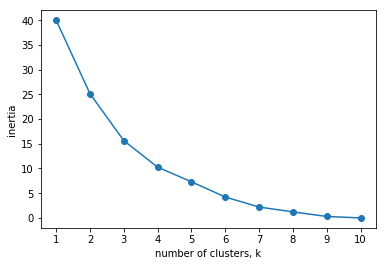

In [101]:
# set number of clusters
ks = range(1, 11)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model=KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(scaled_model_df)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()




### Set best K and run K-Means algorithm
From the plot above, it seems the best elbow point is for K is **6**
Let's run K-Means algorithm.


In [102]:
# run k-means clustering
kclusters=6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scaled_model_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:scaled_model_df.shape[0]]


array([0, 4, 3, 3, 2, 2, 2, 5, 2, 1], dtype=int32)

***
### Let's visualize the resulting clusters on OpenStreetMap

***


In [103]:

neighbourhood_df.set_index(['Neighbourhood','Neighbourhood Postal Code'],inplace=True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
# neighbourhood_model_df = neighbourhood_model_df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
neighbourhood_model_df=model_df.join(neighbourhood_df)

# add clustering labels
neighbourhood_model_df['Cluster Labels'] = kmeans.labels_

neighbourhood_model_df


,,Avg Venue Per Hotel In Given Walking Distance,Avg Walking Time To Hotel,Total Hotel Count,Total Venue Count,Latitude,Longitude,Cluster Labels
Neighbourhood,Neighbourhood Postal Code,,,,,,,
Afrikaanderwijk/Katendrecht,3072,11.400000,541.000000,5,21,51.901861,4.484299,0
Cool/Rotterdam Centrum,3012,10.833333,573.833333,6,14,51.919405,4.475769,4
Coolhaveneiland,3024,14.000000,352.500000,2,18,51.906818,4.457810,3
Dijkzigt,3015,12.333333,411.000000,3,16,51.911750,4.468044,3
Feijenoord/Noordereiland/Kop van Zuid,3071,9.000000,545.000000,1,15,51.911653,4.505364,2
Middelland,3021,8.000000,611.500000,3,16,51.917383,4.459214,2
Oude Westen,3014,9.000000,595.000000,1,16,51.919772,4.466089,2
Rotterdam Centraal/Weena,3013,14.000000,529.500000,1,18,51.924289,4.469251,5
Scheepvaartkwartier/Nieuwe Werk,3016,8.000000,486.000000,1,18,51.906240,4.473647,2


### Show clustered neighbourhoods on OpenStreetMap

In [104]:
showNeighbourdsInMap(neighbourhood_model_df,'Cool, Rotterdam, Netherlands')

The geograpical coordinate of Rotterdam are 51.91831445, 4.47647692560627.


***
# 5. Recommend the neighbourhoods to book hotels
***

Given the below travel requirement of a client, let's predict the best neighbourhoods.
- Client would like to stay in hotels so that all the venues should be in reach by walking 10 minutes
- Client would like stay in an hotel surronded with full of venues so that number venues per hotel in walking distance should be around 18 ( 2 venue per day for his/her 9 days visit) 
- Number of hotels in the neighbourhood should be at least 8 so that she/he can have more choices of price rates.
- Number of venues in the neighbourhood is required to be around 25 



In [105]:
new_hotel_features= {
    'Avg Venue Per Hotel In Given Walking Distance': [18.0],
    'Avg Walking Time To Hotel': [600.0],
    'Total Hotel Count': [8.0],
    'Total Venue Count': [25.0]
}

new_hotel_features_df=pd.DataFrame(new_hotel_features)

new_hotel_features_scaled =scaler.transform(new_hotel_features_df)

new_hotel_labels=kmeans.predict(new_hotel_features_scaled)
print("Recommended Cluster's Label {}".format(new_hotel_labels))

new_hotel_best_neighbourhoods_df=neighbourhood_model_df[neighbourhood_model_df['Cluster Labels'].isin(new_hotel_labels)]
new_hotel_best_neighbourhoods_df


Recommended Cluster's Label [0]


,,Avg Venue Per Hotel In Given Walking Distance,Avg Walking Time To Hotel,Total Hotel Count,Total Venue Count,Latitude,Longitude,Cluster Labels
Neighbourhood,Neighbourhood Postal Code,,,,,,,
Afrikaanderwijk/Katendrecht,3072,11.4,541.0,5,21,51.901861,4.484299,0


### Show recommended neighbourhood on the map

In [106]:
showNeighbourdsInMap(new_hotel_best_neighbourhoods_df,None,new_hotel_best_neighbourhoods_df['Latitude'][0],new_hotel_best_neighbourhoods_df['Longitude'][0])

The geograpical coordinate of Rotterdam are 51.9018612, 4.4842992.
